# Plot difference

In [1]:
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import glob
from scipy.interpolate import griddata
import os
from shutil import copyfile
import re

# Working with directores and files
## Inside the directore must have the invdir, and data folders. If there is no a pngs folder, the code create it for you.

### Another example of path and files:
path_d = "/home/felipe/tmp/AZ/FEB_MAR_2020/data/Sg/test/"

data = [d for d in glob.glob(path_d + "data/*.stg")]


In [2]:
#path_d = "/home/felipe/tmp/AZ/FEB_MAR_2020/data/Sg/test/"
path_d = "/home/felipe/tmp/ERT_model_analyles/OP/"

data = [d for d in glob.glob(path_d + "data/*.stg")]

#path_d = "../Example_files/"
#data = [d for d in glob.glob(path_d + "data/*.tx0")]

In [3]:
if os.path.exists(path_d + "invdir/ref"):
    ref = path_d + "invdir/ref/f001_res.vtk"
    r = path_d + "invdir/ref/f001_rad.dat"
    copyfile(ref,path_d + "invdir/" + "f000_res.vtk")
    copyfile(r,path_d + "invdir/" + "f000_rad.dat") 

files = [f for f in glob.glob(path_d + "invdir/f???_res.vtk")]
rad = [f for f in glob.glob(path_d + "invdir/f???_rad.dat")]

#files = [f for f in glob.glob(path_d + "invdir/*.vtk")]
rad.sort()
files.sort()
data.sort()

if not os.path.exists(path_d + "pngs/dif"):
        os.makedirs(path_d + "pngs/dif")

pngs = [p for p in glob.glob(path_d + "pngs/*.png")]

In [ ]:
rad

In [4]:
# Define the colormap
number_of_color = 2**3 ## not being used. I need to understand better how control the number of colors in cmap & palete
#cmap = plt.cm.gist_earth  # define the colormap
cmap = plt.cm.seismic
#cmaplist = [cmap(i) for i in np.linspace(0,cmap.N+1,number_of_color)]
cmaplist = [cmap(i) for i in range(cmap.N)]
#cmaplist[0] = (0.0, 0.0, 0.0, 1.0)
#cmaplist[0] = (.5, .5, .5, 1.0)
#cmaplist[255] = (1.0, 1.0, 0.0, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

In [5]:
# Define the axes
fig_size = (14, 6)
axes2 = [0.93, 0.1, 0.02, 0.8] # palete

text_size = 12
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

mm = np.zeros(2)
mm[0] = 10000
ref={}
diff=[]
for w,f in enumerate(files):
    if(str(f) not in str(pngs)):
        with open(f,'r') as fh:
            a = ' '
            while 'POINTS' not in a:
                a = (fh.readline().strip())
            string = re.sub('double',' ',re.sub('POINTS',' ', a))
            nnodal = int(string)
            Nodal = []
            Elem = []
            rho_truelog = []
            rho = []
            S = []
            dump = fh.readlines()
            for i, line in enumerate(dump):
                if(i < nnodal):
                    Nodal.append(line.split())
                elif (i == nnodal):
                    n = line.split()
                elif (i < int(n[1])+nnodal+1):
                    Elem.append(line.split())
                elif(i < int(n[1])+nnodal+7):
                    f = line.split()
                elif(i < int(n[1])+nnodal+8):
                    rho = line.split()
                elif(i < int(n[1])+nnodal+10):
                    f = line.split()
                elif(i < int(n[1])+nnodal+11):
                    rho_truelog = line.split()
                elif(i < int(n[1])+nnodal+13):
                    f = line.split()
                elif(i < int(n[1])+nnodal+14):
                    dif = line.split()
                elif(i < int(n[1])+nnodal+16):
                    f = line.split()
                elif(i < int(n[1])+nnodal+17):
                    S = line.split()
        Elem = np.asarray(Elem).astype(int)
        Nodal = np.asarray(Nodal).astype(float)
        S = np.asarray(S).astype(float)
        rho_truelog = np.asarray(rho_truelog).astype(float)
        rho = np.asarray(rho).astype(float)
        
        if (w == 1):
            xmin = min(Nodal[:,0])
            xmax = max(Nodal[:,0]) 
            ymin = min(Nodal[:,1]) #+ ?
            ymax = max(Nodal[:,1]) + 0.5 
        
        for i,e in enumerate(Elem):
            
            index1 = int(e[1]) 
            index2 = int(e[2])
            index3 = int(e[3])
            
            polygon = ((Nodal[index1,0], Nodal[index1,1]), \
                       (Nodal[index2,0],Nodal[index2,1]), \
                       (Nodal[index3,0], Nodal[index3,1]), \
                       (Nodal[index1,0], Nodal[index1,1]))
            
            if(w == 0):
                ref.update({polygon:rho[i]})
            
            diff.append(100.0* ( float(rho[i]) - float(ref[polygon])) / float(ref[polygon])  )
            #diff.append( float(rho[i]) - float(ref[polygon]) )        

# Choose mm (values min and max) based on your data

Mean:  -6.105161439837294 8.821723828331374
Std:  4.8756222622570204 7.3465084696492635


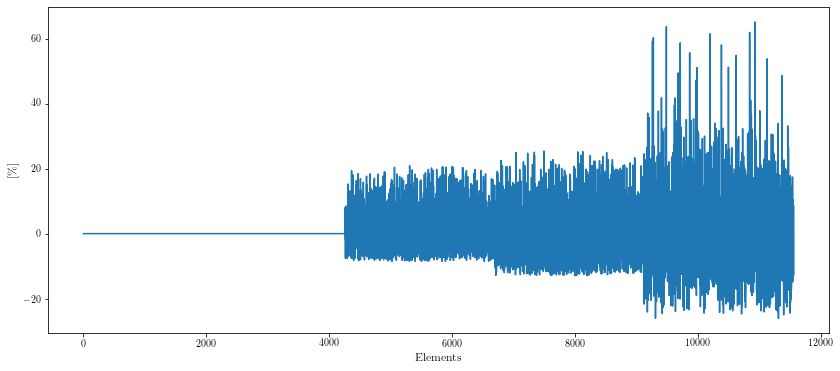

In [6]:
fig, ax = plt.subplots(1, 1, figsize = fig_size)
plt.plot(diff)
ax.set_ylabel("[$\%$]",size=text_size)
ax.set_xlabel("Elements",size=text_size)
a=np.asarray(diff)
print("Mean: ",a[a<0].mean(), a[a>0].mean())
print("Std: ",a[a<0].std(), a[a>0].std())

In [ ]:
rr = np.zeros(len(dump))

for w,f in enumerate(files):
    with open(rad[w],'r') as gh:
        dump = gh.readlines()
        for i, d in enumerate(dump):
            rr[i] = np.asarray(d.split()).astype(float)[2]

In [7]:
S = np.loadtxt("/home/felipe/tmp/ERT_model_analyles/OP/DOI.dat")

In [8]:
Sen = np.asarray(S).astype(float)

Working on /home/felipe/tmp/ERT_model_analyles/OP/invdir/f000_res.vtk
0 6549


/home/felipe/.conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:124: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


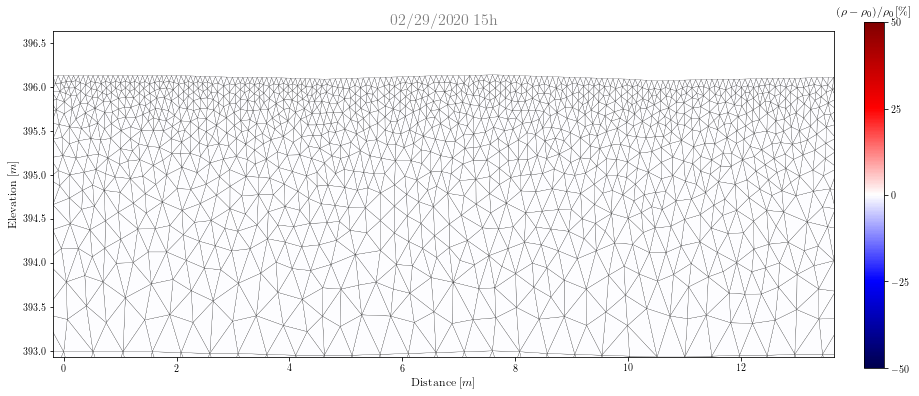

Working on /home/felipe/tmp/ERT_model_analyles/OP/invdir/f001_res.vtk
1 3766


/home/felipe/.conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:124: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


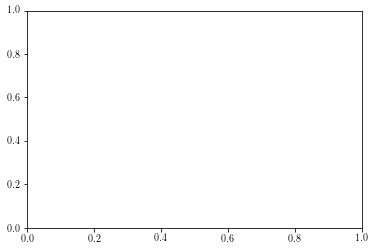

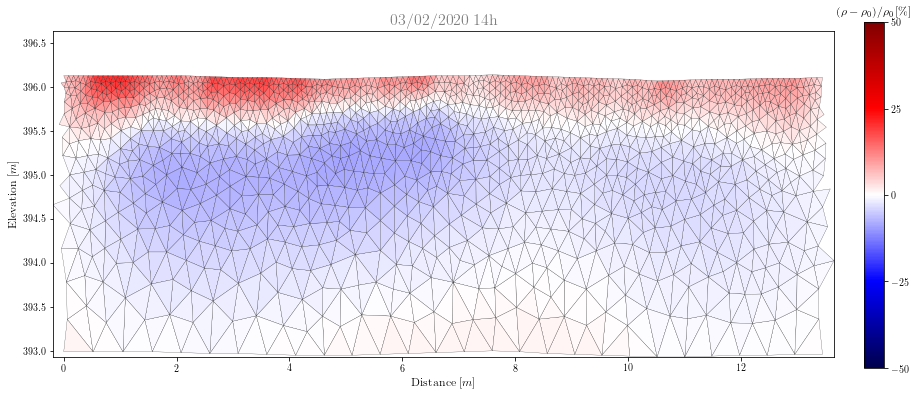

Working on /home/felipe/tmp/ERT_model_analyles/OP/invdir/f002_res.vtk
2 3766


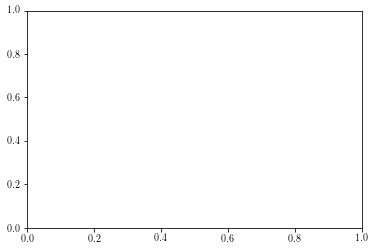

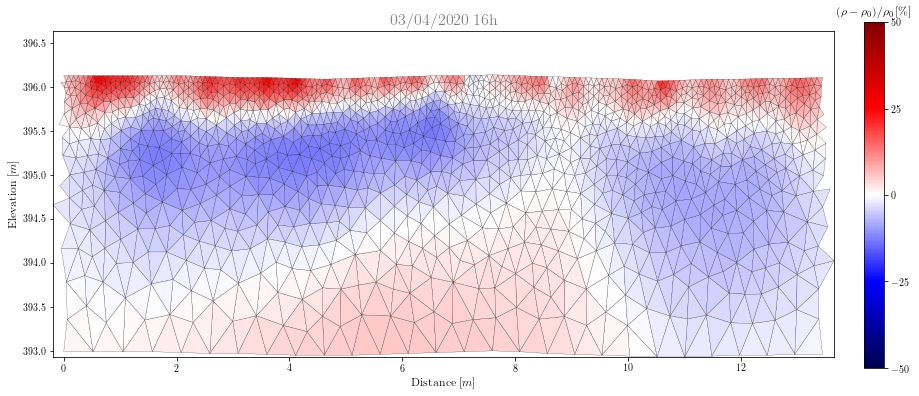

Working on /home/felipe/tmp/ERT_model_analyles/OP/invdir/f003_res.vtk
3 3766


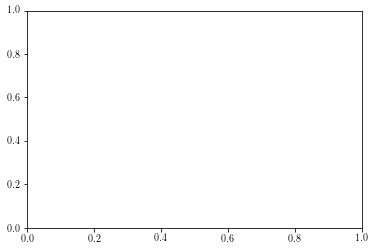

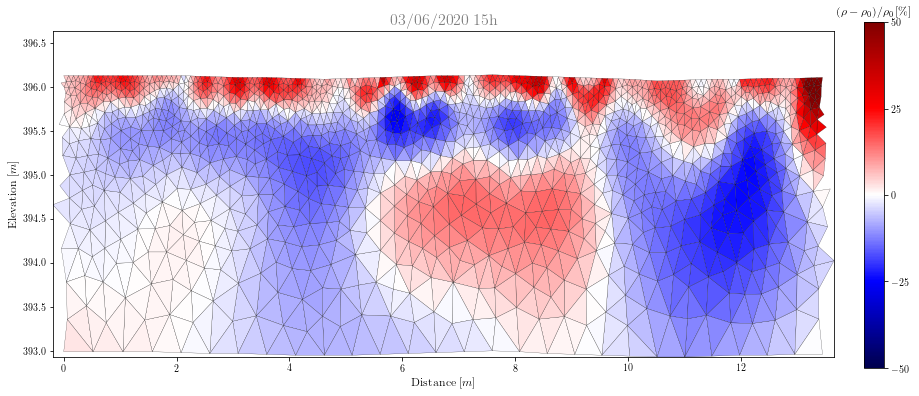



Images saved in /home/felipe/tmp/ERT_model_analyles/OP/pngs/dif/


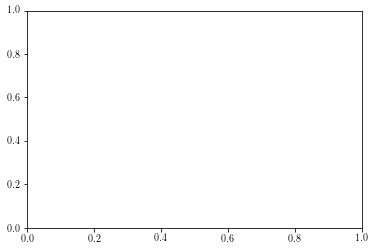

In [9]:
ref = {}
mm = [-50, 50]
bounds = np.linspace(mm[0], mm[1], cmap.N)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
for w,f in enumerate(files):
    if(str(f) not in str(pngs)):
        print("Working on " + f)
                
        fig, ax = plt.subplots(1, 1, figsize = fig_size)
        #xmin = 0; xmax = 13.5
        #ymax = 396.5; ymin = ymax - 1.5 
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(ymin,ymax)
        ax.set_xlabel("Distance [$m$]",size=text_size)
        ax.set_ylabel("Elevation [$m$]",size=text_size)
       
        
        #rr = np.loadtxt(rad[w])
        #rr = np.zeros(len(dump))
        #with open(rad[w],'r') as gh:
        #    dump = gh.readlines()
        #    for i, d in enumerate(dump):
        #        rr[i] = np.asarray(d.split()).astype(float)[2]
        
        with open(f,'r') as fh:
            a = ' '
            while 'POINTS' not in a:
                a = (fh.readline().strip())
            string = re.sub('double',' ',re.sub('POINTS',' ', a))
            nnodal = int(string)
            Nodal = []
            Elem = []
            rho_truelog = []
            rho = []
            S = []
            dump = fh.readlines()
            for i, line in enumerate(dump):
                if(i < nnodal):
                    Nodal.append(line.split())
                elif (i == nnodal):
                    n = line.split()
                elif (i < int(n[1])+nnodal+1):
                    Elem.append(line.split())
                elif(i < int(n[1])+nnodal+7):
                    f = line.split()
                elif(i < int(n[1])+nnodal+8):
                    rho = line.split()
                elif(i < int(n[1])+nnodal+10):
                    f = line.split()
                elif(i < int(n[1])+nnodal+11):
                    rho_truelog = line.split()
                elif(i < int(n[1])+nnodal+13):
                    f = line.split()
                elif(i < int(n[1])+nnodal+14):
                    dif = line.split()
                    print(w,i)
                elif(i < int(n[1])+nnodal+16):
                    f = line.split()
                elif(i < int(n[1])+nnodal+17):
                    S = line.split()
        Elem = np.asarray(Elem).astype(int)
        Nodal = np.asarray(Nodal).astype(float)
        S = np.asarray(S).astype(float)
        rho_truelog = np.asarray(rho_truelog).astype(float)
        rho = np.asarray(rho).astype(float)
        dif = np.asarray(dif).astype(float)
        
        for i,e in enumerate(Elem):
            
            index1 = int(e[1]) 
            index2 = int(e[2])
            index3 = int(e[3])
            
            polygon = ((Nodal[index1,0], Nodal[index1,1]), \
                       (Nodal[index2,0],Nodal[index2,1]), \
                       (Nodal[index3,0], Nodal[index3,1]), \
                       (Nodal[index1,0], Nodal[index1,1]))
            
            with open(rad[w],'r') as gh:
                if(w == 0):
                    ref.update({polygon:rho[i]})
                    r0 = np.zeros(len(rho))
                    dump = gh.readlines()
                    for j, d in enumerate(dump):
                        r0[j] = np.asarray(d.split()).astype(float)[2]
                else:
                    rr = np.zeros(len(rho))
                    dump = gh.readlines()
                    for j, d in enumerate(dump):
                        rr[j] = np.asarray(d.split()).astype(float)[2]
            
            indexC = 100.0*(float(rho[i]) - float(ref[polygon])) / float(ref[polygon])   
            indice = int( (indexC - mm[0])*(len(cmaplist)-1) / (mm[1] - mm[0]))
            
            #if ((indexC - mm[0])*len(cmaplist) / (mm[1] - mm[0]) == 0):
            #    indice = indice + 1
            
            if (indice > 255):
                indice = 255;
            elif(indice < 0):
                indice = 0
            #else:
            #    plotC = cmaplist[indice]  
            plotC = cmaplist[indice] 
            
            codes = [Path.MOVETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY]#patches.append(polygon)
            path = Path(polygon,codes)
       
            patch = patches.PathPatch(path, facecolor=plotC, edgecolor=None, lw=0.2)
            #if(w == 0):
            #    ax.add_patch(patch)
            #else:
            #    if(Sen[i, w] <= 0.2):
            #        ax.add_patch(patch)
            ax.add_patch(patch)
        ax2 = fig.add_axes(axes2)
        #ax2.set_ylabel('Resistivity [$\Omega m$]',size=text_size)
        ax2.set_title('$ (\\rho - \\rho_0) /\\rho_0 \, [\%]$',size=text_size)
        cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=[np.linspace(np.around(mm[0]),np.around(mm[1]),5)], boundaries=bounds)
       
        fname = path_d + 'pngs/dif/' + re.sub(path_d,' ',data[w])[6:-3] + 'png'
        title = re.sub(path_d,' ',fname)[6:-4]
        ax.set_title(title[9:11] + '/' + title[12:14] + '/' + title[4:8] + ' ' + title[15:17] + 'h',fontsize=16, color='gray')
        plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format=None, transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)
        plt.show()
        plt.close(fig)
        plt.clf()
        plt.cla()
        fh.close()
        gh.close()
print("\n\nImages saved in " + path_d + 'pngs/dif/')

In [ ]:
A = np.zeros([2,4])

In [ ]:
A

In [ ]:
np.savetxt("teste.dat",A)

In [ ]:
Sen[100,4]

In [ ]:
print(xmin,xmax,ymin,ymax)